Problem1

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                'acceleration', 'model_year', 'origin', 'car_name']
df = pd.read_csv(url, delim_whitespace=True, names=column_names, na_values='?')

# Select only continuous features (excluding cylinders, model_year, origin which are discrete)
continuous_features = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
df_cont = df[continuous_features]

# Impute missing values with mean
df_cont = df_cont.fillna(df_cont.mean())

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cont)

In [10]:
# Perform hierarchical clustering with average linkage and 3 clusters
cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
clusters = cluster.fit_predict(X_scaled)

df['cluster'] = clusters

In [11]:
def format_stats(stats_df, group_name):
    stats_df.columns = [' '.join(col).strip() for col in stats_df.columns.values]
    stats_df = stats_df.reset_index()
    stats_df.rename(columns={'index': group_name}, inplace=True)
    stats_df = stats_df.round(4)
    return stats_df

cluster_stats = df_cont.groupby(df['cluster']).agg(['mean', 'var'])
print("Cluster Statistics:")
display(format_stats(cluster_stats, 'cluster'))

origin_stats = df_cont.groupby(df['origin']).agg(['mean', 'var'])
print("\nOrigin Statistics:")
display(format_stats(origin_stats, 'origin'))

Cluster Statistics:


,cluster,mpg mean,mpg var,displacement mean,displacement var,horsepower mean,horsepower var,weight mean,weight var,acceleration mean,acceleration var
0,0,26.1774,41.3034,144.3047,3511.4854,86.4910,295.2707,2598.4141,299118.7097,16.4256,4.8752
1,1,14.5289,4.7710,348.0206,2089.4996,161.8041,674.0758,4143.9691,193847.0511,12.6412,3.1899
2,2,43.7000,0.3000,91.7500,12.2500,49.0000,4.0000,2133.7500,21672.9167,22.8750,2.3092



Origin Statistics:


,origin,mpg mean,mpg var,displacement mean,displacement var,horsepower mean,horsepower var,weight mean,weight var,acceleration mean,acceleration var
0,1,20.0835,40.9970,245.9016,9702.6123,118.8148,1569.5323,3361.9317,631695.1284,15.0337,7.5686
1,2,27.8914,45.2112,109.1429,509.9503,81.2420,410.6598,2423.3000,240142.3290,16.7871,9.2762
2,3,30.4506,37.0887,102.7089,535.4654,79.8354,317.5239,2221.2278,102718.4859,16.1722,3.8218


Cross-tabulation of clustering and origin:


origin,1,2,3
cluster,,,
0,152,66,79
1,97,0,0
2,0,4,0



Clustering purity: 0.64


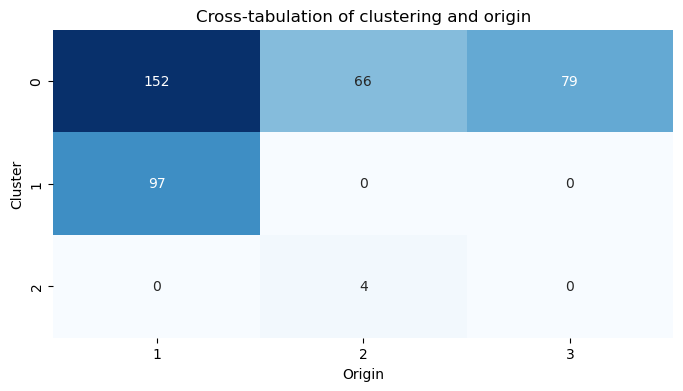

In [12]:
# Create cross-tabulation of clustering and origin
cross_tab = pd.crosstab(df['cluster'], df['origin'])
print("Cross-tabulation of clustering and origin:")
display(cross_tab)

max_per_cluster = cross_tab.max(axis=1)
purity = max_per_cluster.sum() / len(df)
print(f"\nClustering purity: {purity:.2f}")

plt.figure(figsize=(8, 4))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Cross-tabulation of clustering and origin')
plt.xlabel('Origin')
plt.ylabel('Cluster')
plt.show()

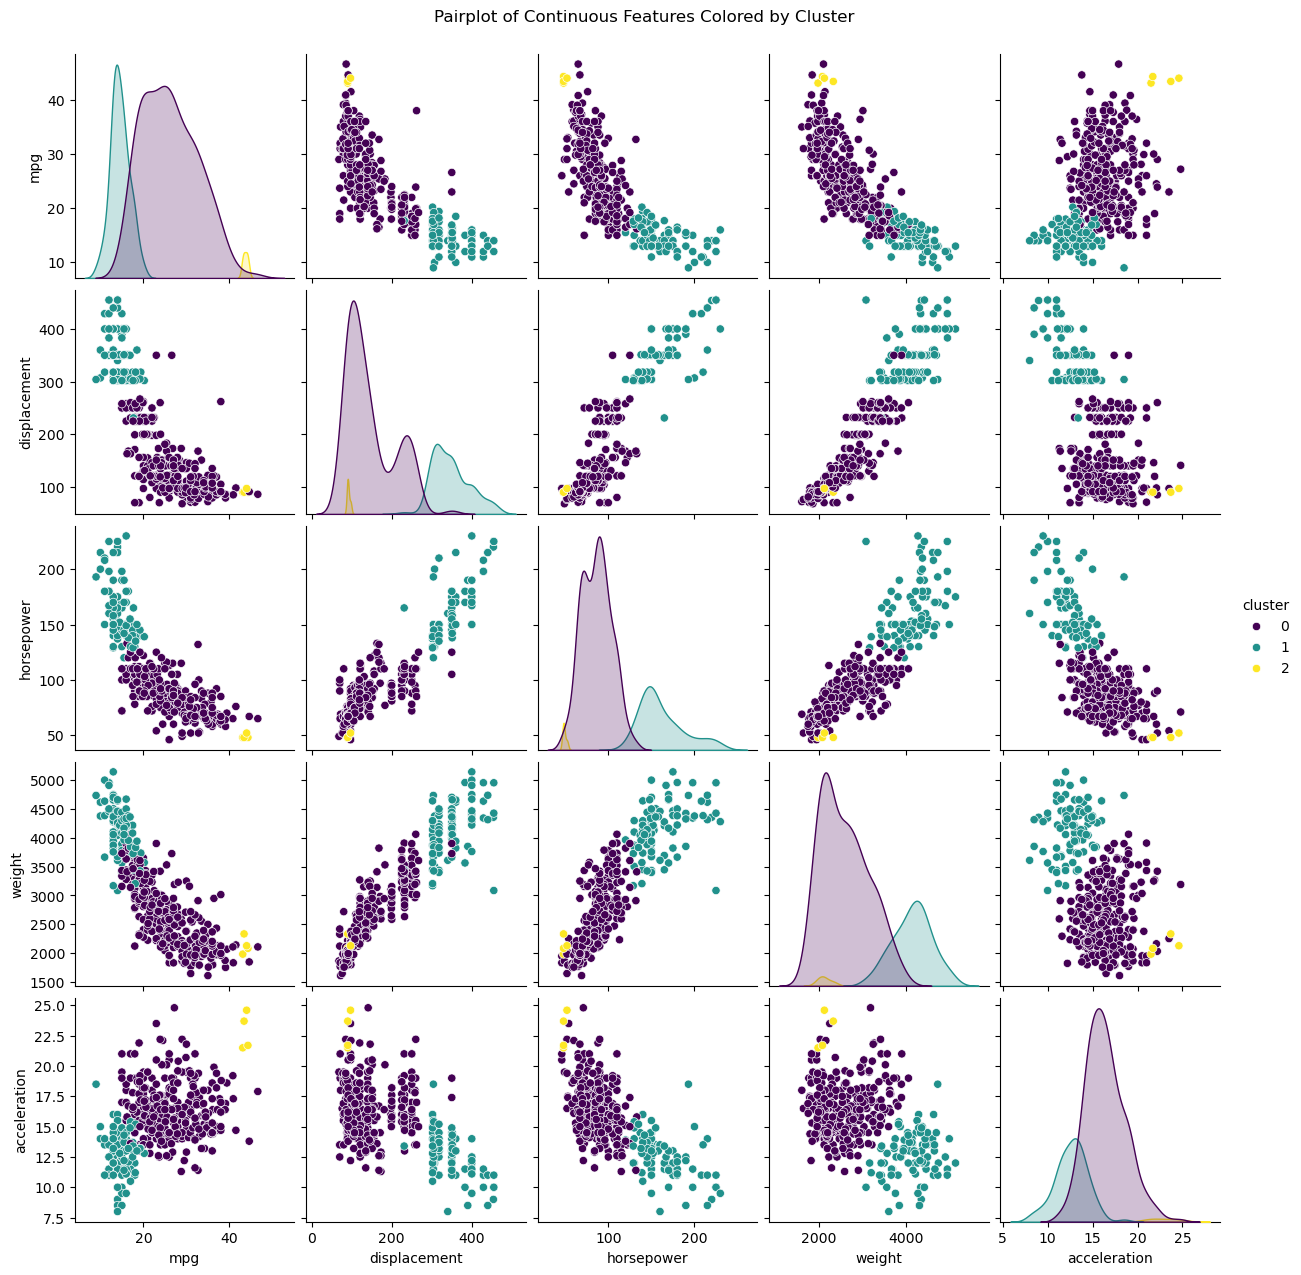

In [13]:
sns.pairplot(df, vars=continuous_features, hue='cluster', palette='viridis')
plt.suptitle("Pairplot of Continuous Features Colored by Cluster", y=1.02)
plt.show()

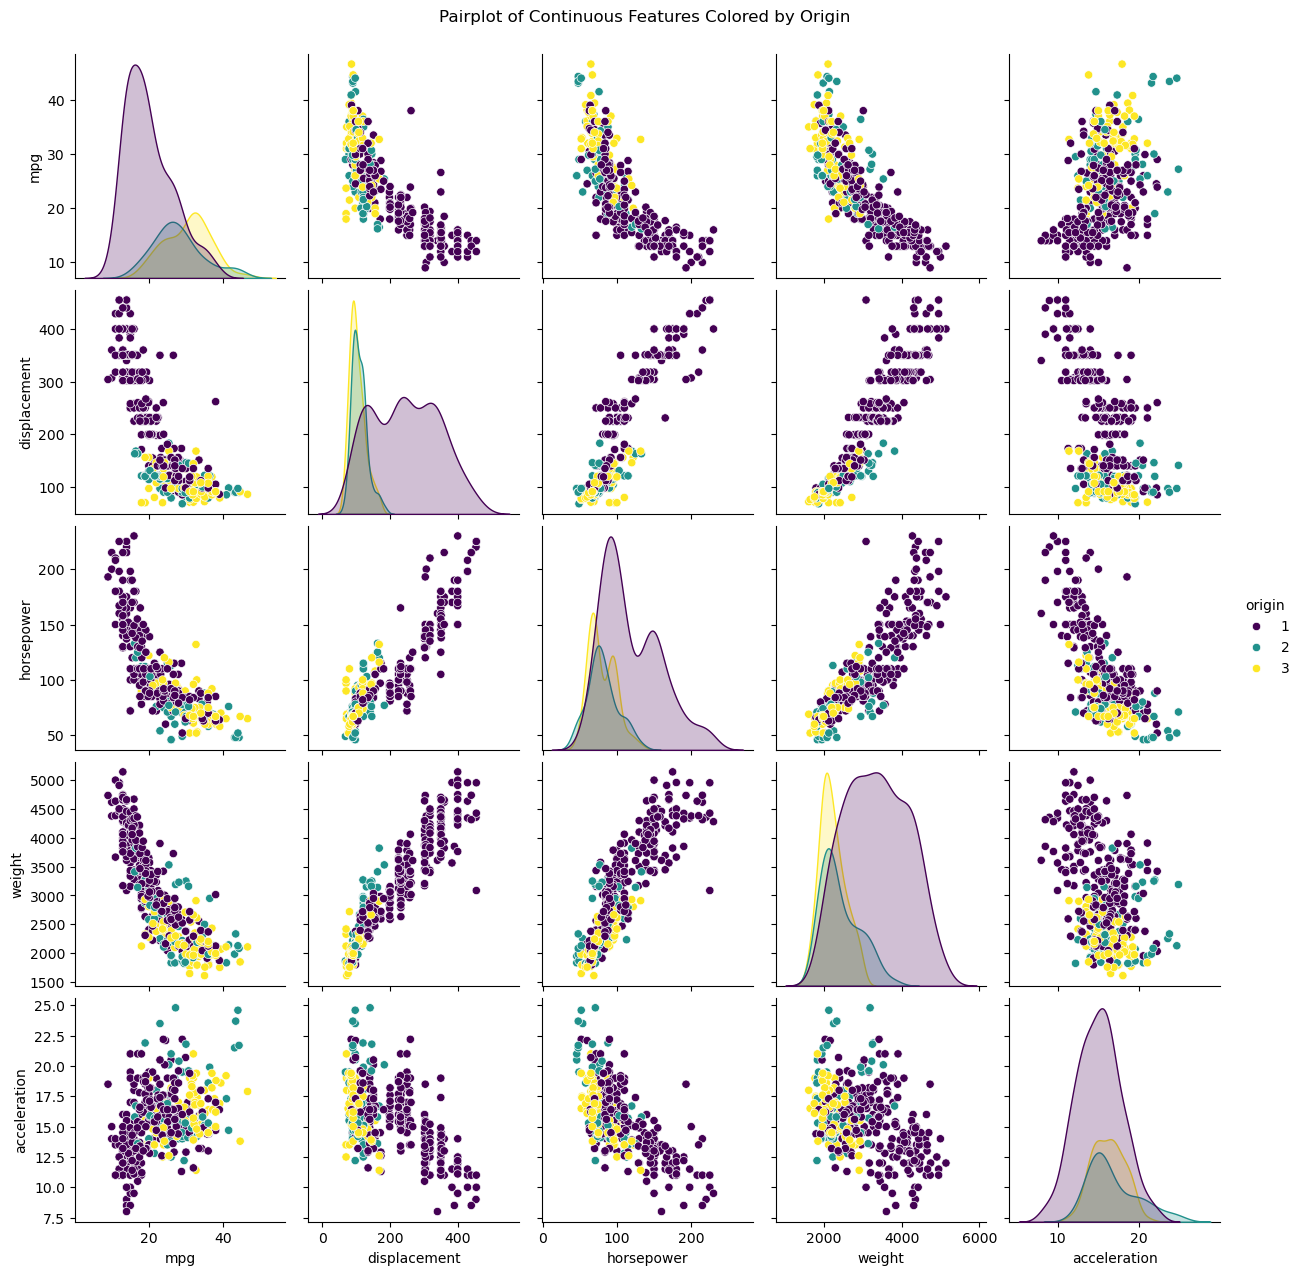

In [14]:
sns.pairplot(df, vars=continuous_features, hue='origin', palette='viridis')
plt.suptitle("Pairplot of Continuous Features Colored by Origin", y=1.02)
plt.show()

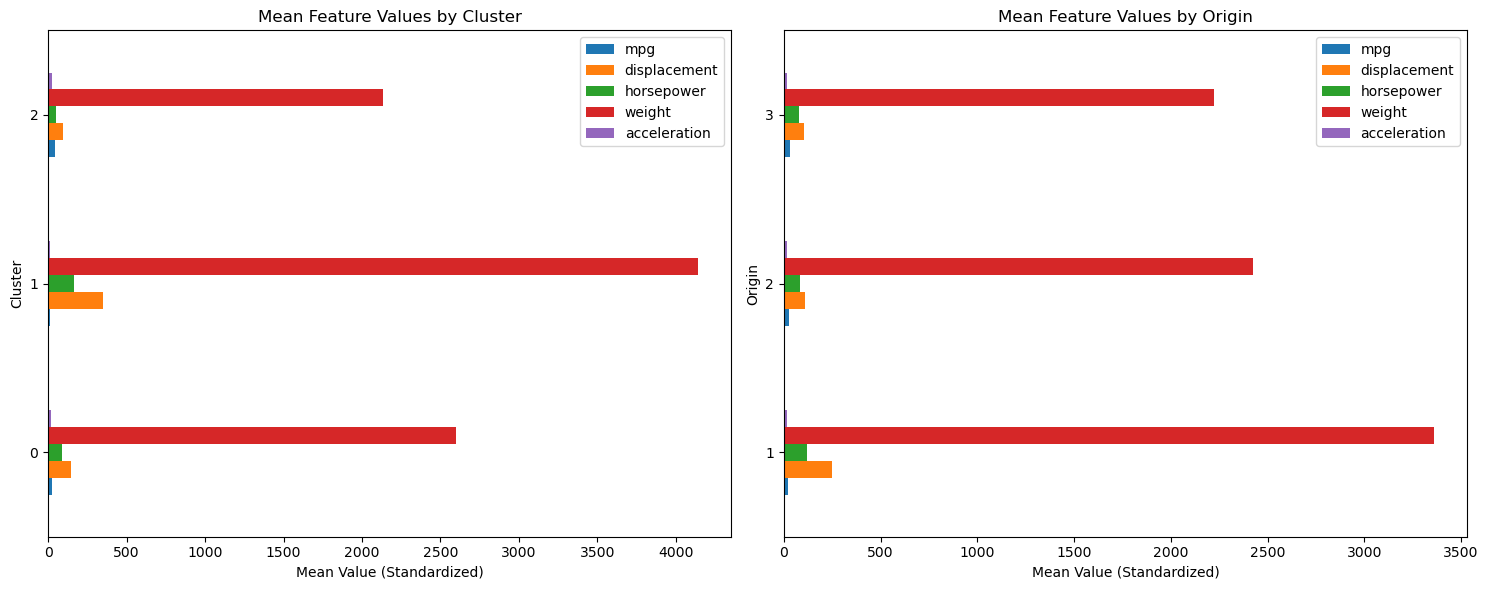

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Cluster means - using horizontal bar plot
cluster_means = df.groupby('cluster')[continuous_features].mean()
cluster_means.plot(kind='barh', ax=axes[0])  
axes[0].set_title('Mean Feature Values by Cluster')
axes[0].set_xlabel('Mean Value (Standardized)') 
axes[0].set_ylabel('Cluster')  

# Origin means - using horizontal bar plot
origin_means = df.groupby('origin')[continuous_features].mean()
origin_means.plot(kind='barh', ax=axes[1])  
axes[1].set_title('Mean Feature Values by Origin')
axes[1].set_xlabel('Mean Value (Standardized)')  
axes[1].set_ylabel('Origin')  

plt.tight_layout()
plt.show()

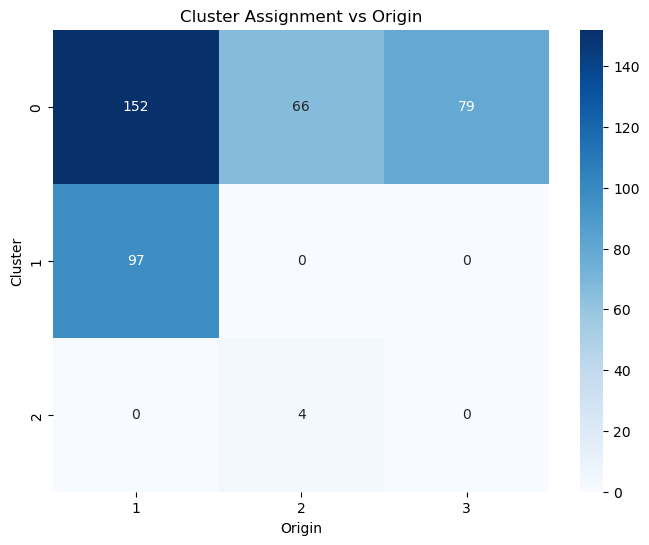

In [16]:
cross_tab = pd.crosstab(df['cluster'], df['origin'])
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster Assignment vs Origin')
plt.xlabel('Origin')
plt.ylabel('Cluster')
plt.show()

Problem2

In [17]:
import warnings
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# Load Boston dataset
boston = fetch_openml(name='boston', version=1, as_frame=True, parser='auto')
df = pd.DataFrame(boston.data, columns=boston.feature_names)

print(df.head())

      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  
0  396.90   4.98  
1  396.90   9.14  
2  392.83   4.03  
3  394.63   2.94  
4  396.90   5.33  


In [18]:
# Separate features (excluding the target MEDV if present)
X = df.drop('MEDV', axis=1) if 'MEDV' in df.columns else df.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 
           'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

k = 3
optimal_model = KMeans(n_clusters=k, random_state=42)
optimal_model.fit(X_scaled)

centroids = scaler.inverse_transform(optimal_model.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df['Cluster'] = centroids_df.index

In [19]:
# Range of clusters to try
k_values = range(2, 7)
silhouette_scores = []

models = {}
labels = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    models[k] = kmeans
    labels[k] = kmeans.labels_

    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}, Silhouette Score: {silhouette_avg:.4f}")

For k=2, Silhouette Score: 0.3601
For k=3, Silhouette Score: 0.2575
For k=4, Silhouette Score: 0.2898
For k=5, Silhouette Score: 0.2878
For k=6, Silhouette Score: 0.2625


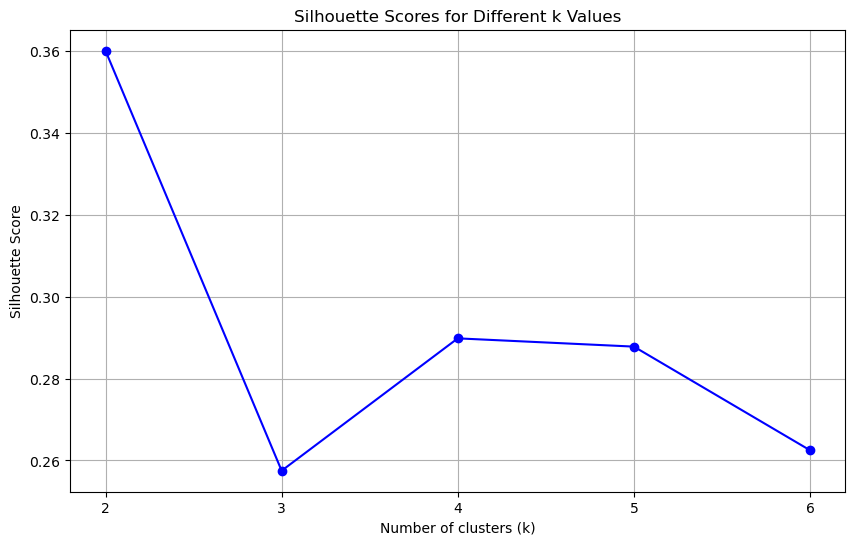

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k Values')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [21]:
# Get the optimal model (assuming k=3 is best)
optimal_k = k_values[np.argmax(silhouette_scores)]
optimal_model = models[optimal_k]
optimal_labels = labels[optimal_k]

print(f"Optimal number of clusters: {optimal_k}")

df['Cluster'] = optimal_labels

Optimal number of clusters: 2


In [22]:
from tabulate import tabulate

features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 
           'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

numeric_df = df[features].apply(pd.to_numeric, errors='coerce')
numeric_df['Cluster'] = optimal_labels 

cluster_means = numeric_df.groupby('Cluster').mean()

centroids_scaled = optimal_model.cluster_centers_

centroids = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids, columns=X.columns)
centroids_df['Cluster'] = centroids_df.index

difference = cluster_means - centroids_df.set_index('Cluster')

def display_nicely(df, title):
    print(f"\n{title}:")
    print(tabulate(df.reset_index(), headers='keys', tablefmt='psql', showindex=False, floatfmt=".4f"))
    print()

display_nicely(cluster_means, "Cluster Means (from original data)")
display_nicely(centroids_df.set_index('Cluster'), "Centroids (inverse transformed from scaled data)")
display_nicely(difference, "Difference between Cluster Means and Centroids")


Cluster Means (from original data):
+-----------+--------+---------+---------+--------+--------+--------+---------+--------+---------+----------+-----------+----------+---------+
|   Cluster |   CRIM |      ZN |   INDUS |   CHAS |    NOX |     RM |     AGE |    DIS |     RAD |      TAX |   PTRATIO |        B |   LSTAT |
|-----------+--------+---------+---------+--------+--------+--------+---------+--------+---------+----------+-----------+----------+---------|
|    0.0000 | 0.2612 | 17.4772 |  6.8850 | 0.0699 | 0.4870 | 6.4554 | 56.3392 | 4.7569 |  4.4711 | 301.9179 |   17.8374 | 386.4479 |  9.4683 |
|    1.0000 | 9.8447 |  0.0000 | 19.0397 | 0.0678 | 0.6805 | 5.9672 | 91.3181 | 2.0072 | 18.9887 | 605.8588 |   19.6045 | 301.3317 | 18.5728 |
+-----------+--------+---------+---------+--------+--------+--------+---------+--------+---------+----------+-----------+----------+---------+


Centroids (inverse transformed from scaled data):
+-----------+--------+---------+---------+--------+--

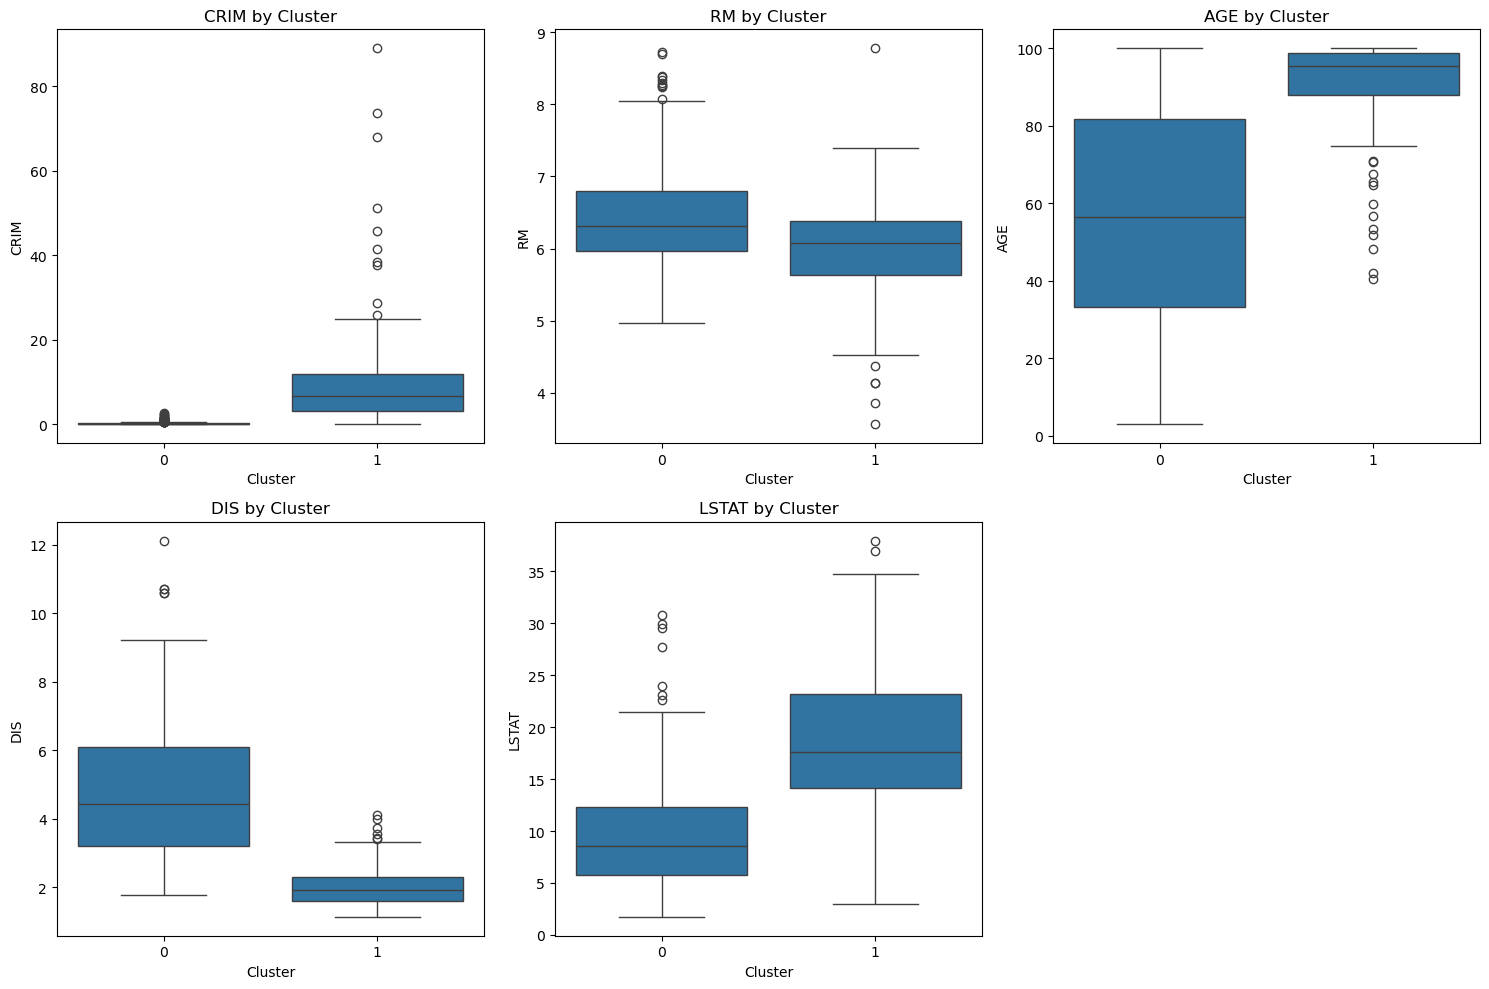

In [23]:
features_to_plot = ['CRIM', 'RM', 'AGE', 'DIS', 'LSTAT']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

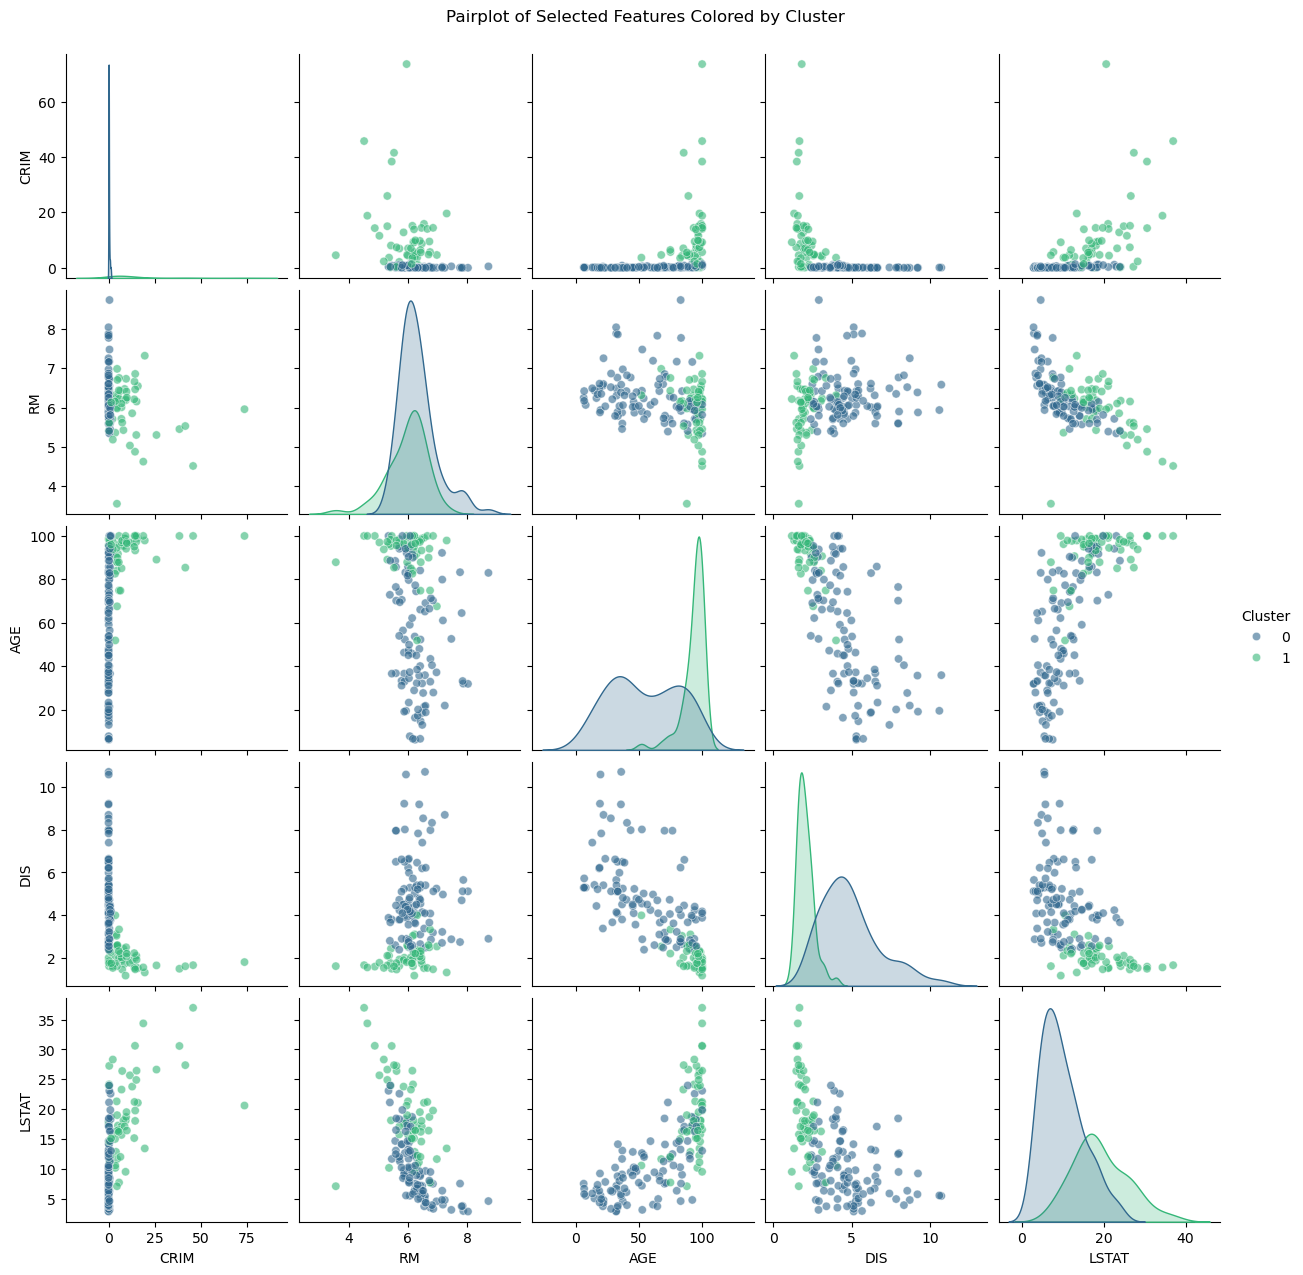

In [24]:
sample_df = df.sample(frac=0.3, random_state=42)

# Create pairplot for selected features
sns.pairplot(sample_df, vars=features_to_plot, hue='Cluster', 
             palette='viridis', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Selected Features Colored by Cluster', y=1.02)
plt.show()

Problem3

In [25]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
# Load the wine dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(wine.data)

In [26]:
# Perform K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

homogeneity = homogeneity_score(wine.target, clusters)
completeness = completeness_score(wine.target, clusters)
v_measure = v_measure_score(wine.target, clusters)

print(f"Homogeneity score: {homogeneity:.3f}")
print(f"Completeness score: {completeness:.3f}")
print(f"V-measure score: {v_measure:.3f}")

Homogeneity score: 0.879
Completeness score: 0.873
V-measure score: 0.876


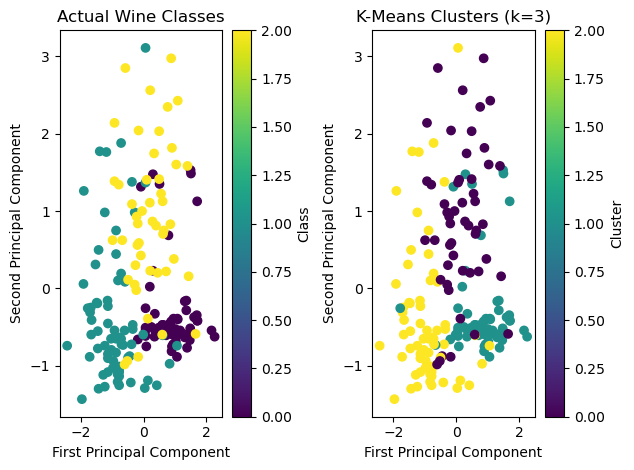

In [27]:
# Plot actual classes
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=wine.target, cmap='viridis')
plt.title('Actual Wine Classes')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Class')

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clusters (k=3)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

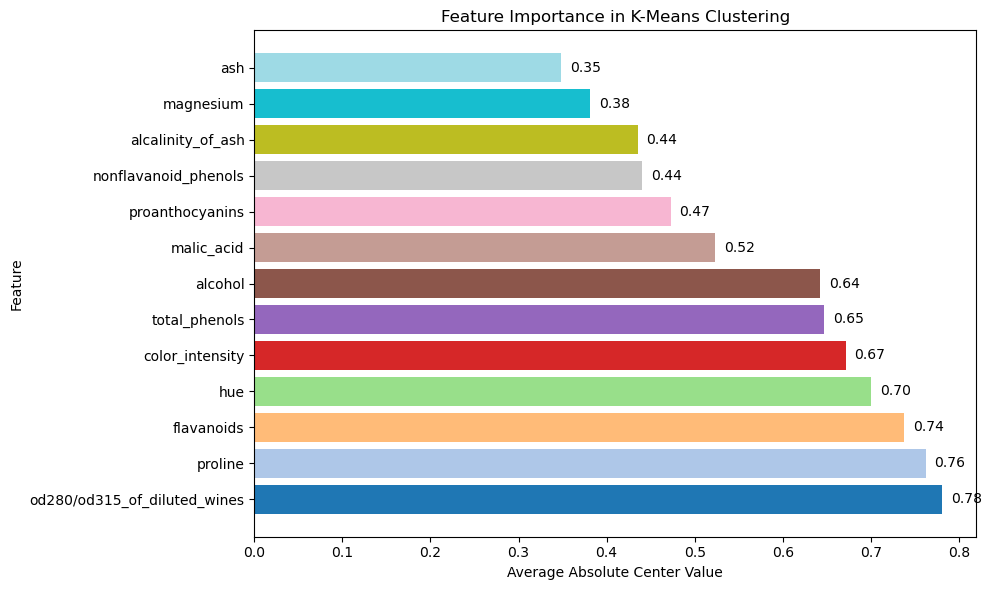

In [28]:
# Visualization 2: Feature importance for clustering with distinct colors
feature_importance = pd.DataFrame({
    'Feature': wine.feature_names,
    'Importance': np.abs(kmeans.cluster_centers_).mean(axis=0)
}).sort_values('Importance', ascending=False)

colors = plt.colormaps['tab20'].resampled(len(feature_importance))

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance['Feature'], 
                feature_importance['Importance'],
                color=colors(range(len(feature_importance))))

plt.title('Feature Importance in K-Means Clustering')
plt.xlabel('Average Absolute Center Value')
plt.ylabel('Feature')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             va='center')

plt.tight_layout()
plt.show()